In [1]:
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyplr.stlabhelp import make_video_file, get_led_colors
from pysilsub.problems import SilentSubstitutionProblem as SSP
from pysilsub.CIE import get_CIE_1924_photopic_vl, get_CIES026_action_spectra


MINTENSITY = 0
MAXTENSITY = 4095
BACKGROUND = MAXTENSITY/2
Fs = 100
vl = get_CIE_1924_photopic_vl()
lms = get_CIES026_action_spectra()

def get_sinusoid_time_vector(duration):
    return np.arange(0, (duration * 1000), 10).astype("int")


def sinusoid_modulation(f, duration, Fs=100):
    x  = np.arange(duration * Fs)
    return np.sin(2 * np.pi * f * x / Fs)


def modulate_intensity_amplitude(sm, background, amplitude):
    return (background + (sm * amplitude)).astype("int")


ssp1 = SSP.from_package_data('STLAB_1_York')

ssp1.ignore = ['rh']
ssp1.target = ['sc']
ssp1.silence = ['mc', 'lc', 'mel']
ssp1.background = [.5] * ssp1.nprimaries
ssp1.target_contrast = .0

frequency = [2.0]
contrast = [4.]
seconds = 12

for f, c in product(frequency, contrast):
    stimulus_profile = sinusoid_modulation(f, seconds, Fs)*.4

    contrast_mods = []
    for tc in stimulus_profile:
        ssp1.target_contrast = tc
        contrast_mods.append(ssp1.linalg_solve())
    
    cycle_mod = pd.concat(contrast_mods, axis=1).T.mul(4096).astype('int')
    
    cycle_mod.columns = ['LED-' + str(c) for c in cycle_mod.columns]
    cycle_mod['time'] = get_sinusoid_time_vector(seconds)
    cols = cycle_mod.columns.to_list()
    cols = cols[-1:] + cols[:-1]
    
    cycle_mod = cycle_mod[cols]

    metadata = {
        'title': '2 Hz S-cone modulation',
        'seconds': seconds, 
        'contrast': c,
        'frequency': f
        }
    make_video_file(cycle_mod, repeats=1, fname=f'c{c}_f{f}', **metadata)

Saved video file: c4.0_f2.0


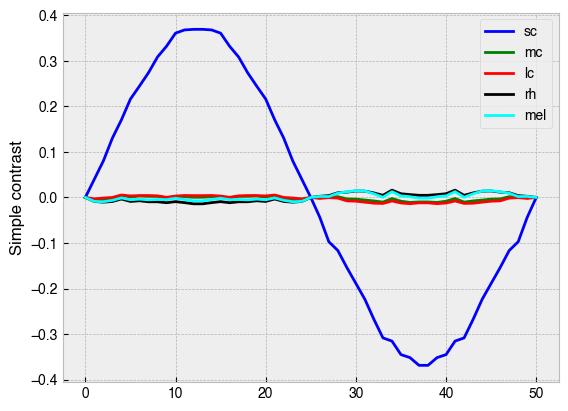

In [2]:
splatter = [ssp1.get_photoreceptor_contrasts(cm) for cm in contrast_mods[0:51]]
splatter = np.vstack(splatter)

plt.plot(splatter[:,0], label='sc', c='b')
plt.plot(splatter[:,1], label='mc', c='g')
plt.plot(splatter[:,2], label='lc', c='r')
plt.plot(splatter[:,3], label='rh', c='k')
plt.plot(splatter[:,4], label='mel', c='cyan')
plt.ylabel('Simple contrast')
plt.legend()

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib widget

background = ssp1.predict_multiprimary_spd(ssp1.background)
contrast_mods = contrast_mods[0:50]

0 sc tab:blue
1 mc tab:green
2 lc tab:red
3 rh tab:grey
4 mel tab:cyan


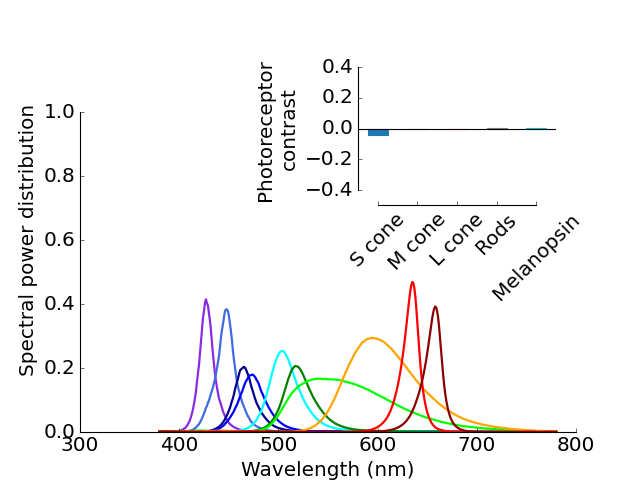

In [61]:
plt.style.use('classic')
plt.rcParams['font.size'] = 18
import seaborn as sns
fig = plt.figure()

ax = plt.axes(xlim=(300, 800), ylim=(0, 2e06))
ax.set_xlabel('Wavelength (nm)')
ax.set_ylim((0,1.2))
ax.set_ylabel('Spectral power distribution')
x = np.arange(380, 781, 1)
t = ax.text(.01, .7, '', fontsize=12, transform=ax.transAxes)
sns.despine(ax=ax, trim=True)
ax.tick_params(
    axis='y',    
    which='both',
    left=True,     
    right=False
)
ax.tick_params(
    axis='x',          
    which='both',      
    bottom=True,      
    top=False,         
    labelbottom=True
)
axin = ax.inset_axes([.56, .59, .4, .4])
sns.despine(ax=axin, trim=True)

# axim = ax.inset_axes([-0.01, .6, .38, .38])
# img = plt.imread('../logo/photoreceptor_characters_alt.png')
# axim.imshow(img)
# axim.grid(False)
# axim.axis('off')
# sns.despine(ax=axim, left=True, bottom=True)

lines = []
for p, c in zip(ssp1.primaries, ssp1.primary_colors):
    line, = ax.plot([], [], lw=2, color=c, label=f'Primary {p}')
    lines.append(line)

bars = []
for i, (p, c) in enumerate(zip(ssp1.observer.photoreceptor_colors.keys(), ssp1.observer.photoreceptor_colors.values())):
    print(i,p,c)
    bar, = axin.bar(i, 0, color=c, label=f'{p}')
    bars.append(bar)

    #text = []
#for p, c in zip(ssp1.primaries, ssp1.colors):
#    text, = ax.text([], [], lw=2, color=c, label=f'Primary {p}')
#    text.append(text)

#ax.legend(loc='center left', fontsize=12, frameon=False)

def init():
    for line in lines:
        line.set_data([], [])
    return (lines, )

def animate(i):
    primaries = ssp1.predict_multiprimary_spd(contrast_mods[i], nosum=True).T
    contrasts = ssp1.get_photoreceptor_contrasts(contrast_mods[i])

    for lnum,line in enumerate(lines):
        line.set_data(x, primaries.loc[lnum]) # set data for each line separately. 
    
    #string = contrasts.to_frame().mul(100).round(2).to_string(justify='center', header=False, index_names=False)
    #t.set_text(string)
    axin.cla()
    axin.set_ylim((-.5, .5))
    axin.set_ylabel('Photoreceptor \ncontrast')
    ao = ssp1.get_photoreceptor_contrasts(contrast_mods[i])
    ao.plot(ax=axin, kind='bar', color=ssp1.observer.photoreceptor_colors.values(), rot=45, edgecolor=ssp1.observer.photoreceptor_colors.values())
    axin.set_xticklabels(['S cone', 'M cone', 'L cone', 'Rods', 'Melanopsin'])
    axin.axhline(0, c='k')
    sns.despine(ax=axin, trim=True)
    axin.tick_params(
        axis='x',          
        which='both',      
        bottom=True,      
        top=False,         
        labelbottom=True)
    axin.tick_params(
        axis='y',    
        which='both',
        left=True,     
        right=False
    )
    return (lines,)

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(contrast_mods), 
                               interval=1, blit=True)

anim.save('ss_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
anim.save('ss_basic_animation.gif', fps=30, writer='imagemagick')